# SLAM Unit D - Part 3
Finally, building the Kalman filter for our robot. On our way, we will introduce the extended Kalman filter.

In [77]:
# If you don't see a video below, run this cell.
# YouTube = True  # Uncomment to get YouTube videos instead of TIB AV.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/U2fE1AkmGmg" if "YouTube" in globals() else "//av.tib.eu/player/49011",
       width=560, height=315)

## First, the prediction step
We need the following parts:

- The transformation of the state itself. We will call it $g()$. This is just the implementation of the nonlinear motion model, as we learned it in Unit A (and as repeated in the video).
- The Jacobian matrix of this transformation, the derivative with respect to the state. This is $G=\partial g/\partial(x,y,\theta)$.
- The Jacobian matrix, derivative with respect to control. This is $V=\partial g/\partial(l,r)$.

Once we have all these components, we can put them together to obtain the prediction step of the Kalman filter.

### Part 1: The transformation of the state.
This is from Unit A and I have implemented it for you already. Run the cell below to reproduce the results from the above video, then run the next but one cell to view the results.

In [78]:
# This introduces the extended Kalman Filter class.
# The computational steps are the same as in Unit A,
# slam_02_b_filter_motor_file.
#
# slam_07_a_extended_kalman_filter_class
from lego_robot import *
from numpy import *

class ExtendedKalmanFilter_1:

    @staticmethod
    def g(state, control, w):
        x, y, theta = state
        l, r = control
        if r != l:
            alpha = (r - l) / w
            rad = l/alpha
            g1 = x + (rad + w/2.)*(sin(theta+alpha) - sin(theta))
            g2 = y + (rad + w/2.)*(-cos(theta+alpha) + cos(theta))
            g3 = (theta + alpha + pi) % (2*pi) - pi
        else:
            g1 = x + l * cos(theta)
            g2 = y + l * sin(theta)
            g3 = theta

        return array([g1, g2, g3])


if __name__ == '__main__':
    # Constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Measured start position.
    state = array([1850.0, 1897.0, 213.0 / 180.0 * pi])

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")

    # Loop over all motor tick records and generate a filtered position list.
    states = []
    for ticks in logfile.motor_ticks:
        # Prediction (so far only predicts state, not covariance).
        control = array(ticks) * ticks_to_mm
        state = ExtendedKalmanFilter_1.g(state, control, robot_width)

        # Log state.
        states.append(state)

    # Write all states to file.
    f = open("states_from_ticks.txt", "w")
    for s in states:
        # Output the center of the scanner, not the center of the robot.
        print("F %f %f %f" % \
            tuple(s + [scanner_displacement * cos(s[2]),
                       scanner_displacement * sin(s[2]),
                       0.0]), file=f)
    f.close()

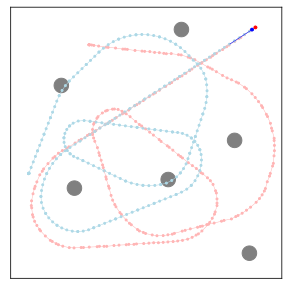

In [79]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["states_from_ticks.txt", "robot4_reference.txt", "robot_arena_landmarks.txt"])

### Part 2: The derivative with respect to the state. Programming assignment (10 Points).

In [80]:
# This adds the derivative of g with respect to the state (x, y and heading)
# to the class.
#
# slam_07_b_state_derivative
from numpy import *

class ExtendedKalmanFilter_2(ExtendedKalmanFilter_1):

    @staticmethod
    def dg_dstate(state, control, w):
        theta = state[2]
        l, r = control
        alpha=(r-l)/w
        R=l/alpha

        if r != l:

            # --->>> Put your code here.
            # This is for the case r != l.
            # g has 3 components and the state has 3 components, so the
            # derivative of g with respect to all state variables is a
            # 3x3 matrix. To construct such a matrix in Python/Numpy,
            # use: m = array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
            # where 1, 2, 3 are the values of the first row of the matrix.
            # Don't forget to return this matrix.
            dg11=1
            dg12=0
            dg13=(R+w/2)*(cos(theta+alpha)-cos(theta))
            dg21=0
            dg22=1
            dg23=(R+w/2)*(sin(theta+alpha)-sin(theta))
            dg31=0
            dg32=0
            dg33=1

            m = array([[dg11, dg12, dg13], [dg21, dg22, dg23], [dg31, dg32, dg33]])  # Replace this.

        else:
            dg11=1
            dg12=0
            dg13=-l*sin(theta)
            dg21=0
            dg22=1
            dg23=l*cos(theta)
            dg31=0
            dg32=0
            dg33=1

            # --->>> Put your code here.
            # This is for the special case r == l.
            m = array([[dg11, dg12, dg13], [dg21, dg22, dg23], [dg31, dg32, dg33]]) # Replace this.

        # YOUR CODE HERE
        #raise NotImplementedError()

        return m

if __name__ == '__main__':
    # If the partial derivative with respect to x, y and theta (the state)
    # are correct, then the numerical derivative and the analytical
    # derivative should be the same.

    # Set some variables. Try other values as well.
    # In particular, you should check cases with l == r and l != r.
    x = 10.0
    y = 20.0
    theta = 35. / 180. * pi
    state = array([x, y, theta])
    l = 50.0
    r = 54.32
    control = array([l, r])
    w = 150.0

    # Compute derivative numerically.
    print("Numeric differentiation dx, dy, dtheta:")
    delta = 1e-7
    state_x = array([x + delta, y, theta])
    state_y = array([x, y + delta, theta])
    state_theta = array([x, y, theta + delta])
    gval = ExtendedKalmanFilter_2.g(state, control, w)
    dg_dx = (ExtendedKalmanFilter_2.g(state_x, control, w) - gval) / delta
    dg_dy = (ExtendedKalmanFilter_2.g(state_y, control, w) - gval) / delta
    dg_dtheta = (ExtendedKalmanFilter_2.g(state_theta, control, w) - gval) / delta
    dg_dstate_numeric = column_stack([dg_dx, dg_dy, dg_dtheta])
    print(dg_dstate_numeric)

    # Use the above code to compute the derivative analytically.
    print("Analytic differentiation dx, dy, dtheta:")
    dg_dstate_analytic = ExtendedKalmanFilter_2.dg_dstate(state, control, w)
    print(dg_dstate_analytic)

    # The difference should be close to zero (depending on the setting of
    # delta, above).
    print("Difference:")
    print(dg_dstate_numeric - dg_dstate_analytic)
    print("Seems correct:", allclose(dg_dstate_numeric, dg_dstate_analytic))

Numeric differentiation dx, dy, dtheta:
[[  1.00000001   0.         -30.52883876]
 [  0.           1.00000001  42.29027837]
 [  0.           0.           1.        ]]
Analytic differentiation dx, dy, dtheta:
[[  1.           0.         -30.52883711]
 [  0.           1.          42.29027852]
 [  0.           0.           1.        ]]
Difference:
[[ 1.16860974e-08  0.00000000e+00 -1.65049057e-06]
 [ 0.00000000e+00  1.16860974e-08 -1.47597937e-07]
 [ 0.00000000e+00  0.00000000e+00 -1.63657887e-09]]
Seems correct: True


In [81]:
# Test of the derivative with respect to the state.
from numpy import *
class ExtendedKalmanFilterRef:
    @staticmethod
    def g(state, control, w):
        x, y, theta = state
        l, r = control
        if r != l:
            alpha = (r - l) / w
            rad = l/alpha
            g1 = x + (rad + w/2.)*(sin(theta+alpha) - sin(theta))
            g2 = y + (rad + w/2.)*(-cos(theta+alpha) + cos(theta))
            g3 = (theta + alpha + pi) % (2*pi) - pi
        else:
            g1 = x + l * cos(theta)
            g2 = y + l * sin(theta)
            g3 = theta
        return array([g1, g2, g3])

def public_test(the_kf_class):
    for experiment in range(1000):
        # If the partial derivative with respect to x, y and theta (the state)
        # are correct, then the numerical derivative and the analytical
        # derivative should be the same.

        # Set variables randomly.
        x = random.uniform(-10,10)
        y = random.uniform(-10,10)
        theta = random.uniform(-180, 180) / 180. * pi
        state = array([x, y, theta])
        l = random.uniform(-50, 50)
        r = random.uniform(-50, 50)
        if random.random() > 0.9: r = l  # Test r=l cases.
        elif abs(r-l) < 0.1: r += 0.2  # Avoid numeric instabilities.
        control = array([l, r])
        w = 150.0

        # Compute derivative numerically.
        delta = 1e-7
        state_x = array([x + delta, y, theta])
        state_y = array([x, y + delta, theta])
        state_theta = array([x, y, theta + delta])
        gval = ExtendedKalmanFilterRef.g(state, control, w)
        dg_dx = (ExtendedKalmanFilterRef.g(state_x, control, w) - gval) / delta
        dg_dy = (ExtendedKalmanFilterRef.g(state_y, control, w) - gval) / delta
        dg_dtheta = (ExtendedKalmanFilterRef.g(state_theta, control, w) - gval) / delta
        dg_dstate_numeric = column_stack([dg_dx, dg_dy, dg_dtheta])

        # Use the above code to compute the derivative analytically.
        dg_dstate_analytic = the_kf_class.dg_dstate(state, control, w)

        # The difference should be close to zero (depending on the setting of
        # delta, above).
        is_close = allclose(dg_dstate_numeric, dg_dstate_analytic, atol=1e-5)
        if not is_close:
            print("For state:")
            print(state)
            print("...and control:")
            print(control)
            print("...the result of the numeric differentiation is:")
            print(dg_dstate_numeric)
            print("...your analytical result is:")
            print(dg_dstate_analytic)
            print("...resulting in a difference of:")
            print(dg_dstate_numeric - dg_dstate_analytic)
            return False
    return True
assert public_test(ExtendedKalmanFilter_2)

<ipython-input-80-1219ba714060>:14: RuntimeWarning: divide by zero encountered in double_scalars
  R=l/alpha


### Part 3: The derivative with respect to control.

In [82]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/QLslcjSF4GQ" if "YouTube" in globals() else "//av.tib.eu/player/49012",
       width=560, height=315)

### Programming assignment. Implement the Jacobian matrix: derivative with respect to control (10 Points).

In [83]:
# This adds the derivative of g, this time with respect to the control
# (left and right motor movement).
#
# slam_07_c_control_derivative
from numpy import *

class ExtendedKalmanFilter_3(ExtendedKalmanFilter_2):

    @staticmethod
    def dg_dcontrol(state, control, w):
        theta = state[2]
        l, r = tuple(control)
        alpha=(r-l)/w
        
        if r != l:

            # --->>> Put your code here.
            # This is for the case l != r.
            # Note g has 3 components and control has 2, so the result
            # will be a 3x2 (rows x columns) matrix.
            #pass  # Remove this.
            dg11=w*r/((r-l)**2)*(sin(theta+alpha)-sin(theta))-(r+l)/2/(r-l)*cos(theta+alpha)
            dg21=w*r/((r-l)**2)*(-cos(theta+alpha)+cos(theta))-(r+l)/2/(r-l)*sin(theta+alpha)
            dg31=-1/w
            dg12=-w*l/((r-l)**2)*(sin(theta+alpha)-sin(theta))+(r+l)/2/(r-l)*cos(theta+alpha)
            dg22=-w*l/((r-l)**2)*(-cos(theta+alpha)+cos(theta))+(r+l)/2/(r-l)*sin(theta+alpha)
            dg32=1/w
        else:

            # --->>> Put your code here.
            # This is for the special case l == r.
            #pass  # Remove this.       
            dg11=1/2*(cos(theta)+l/w*sin(theta))
            dg21=1/2*(sin(theta)-l/w*cos(theta))   
            dg31=-1/w
            dg12=1/2*(cos(theta)-l/w*sin(theta))  
            dg22=1/2*(sin(theta)+l/w*cos(theta))
            dg32=1/w

        m = array([[dg11, dg12], [dg21, dg22], [dg31, dg32]])  # Remove this.

        # YOUR CODE HERE
        #raise NotImplementedError()
            
        return m


if __name__ == '__main__':
    # If the partial derivative with respect to l and r (the control)
    # are correct, then the numerical derivative and the analytical
    # derivative should be the same.

    # Set some variables. Try other values as well.
    x = 10.0
    y = 20.0
    theta = 35. / 180. * pi
    state = array([x, y, theta])
    l = 50.0
    r = 54.32
    control = array([l, r])
    w = 150.0

    # Compute derivative numerically.
    print("Numeric differentiation dl, dr")
    delta = 1e-7
    control_l = array([l + delta, r])
    control_r = array([l, r + delta])
    gval = ExtendedKalmanFilter_3.g(state, control, w)
    dg_dl = (ExtendedKalmanFilter_3.g(state, control_l, w) - gval) / delta
    dg_dr = (ExtendedKalmanFilter_3.g(state, control_r, w) - gval) / delta
    dg_dcontrol_numeric = column_stack([dg_dl, dg_dr])
    print(dg_dcontrol_numeric)

    # Use the above code to compute the derivative analytically.
    print("Analytic differentiation dl, dr:")
    dg_dcontrol_analytic = ExtendedKalmanFilter_3.dg_dcontrol(state, control, w)
    print(dg_dcontrol_analytic)

    # The difference should be close to zero (depending on the setting of
    # delta, above).
    print("Difference:")
    print(dg_dcontrol_numeric - dg_dcontrol_analytic)
    print("Seems correct:", allclose(dg_dcontrol_numeric, dg_dcontrol_analytic))

Numeric differentiation dl, dr
[[ 0.50782837  0.30294956]
 [ 0.15216777  0.43312447]
 [-0.00666667  0.00666666]]
Analytic differentiation dl, dr:
[[ 0.50782938  0.3029505 ]
 [ 0.15216693  0.43312519]
 [-0.00666667  0.00666667]]
Difference:
[[-1.00908249e-06 -9.36841854e-07]
 [ 8.37353119e-07 -7.18581610e-07]
 [-5.51602473e-10 -3.88928963e-09]]
Seems correct: True


In [84]:
# Test of the derivative with respect to control.
from numpy import *
class ExtendedKalmanFilterRef:
    @staticmethod
    def g(state, control, w):
        x, y, theta = state
        l, r = control
        if r != l:
            alpha = (r - l) / w
            rad = l/alpha
            g1 = x + (rad + w/2.)*(sin(theta+alpha) - sin(theta))
            g2 = y + (rad + w/2.)*(-cos(theta+alpha) + cos(theta))
            g3 = (theta + alpha + pi) % (2*pi) - pi
        else:
            g1 = x + l * cos(theta)
            g2 = y + l * sin(theta)
            g3 = theta
        return array([g1, g2, g3])

def public_test(the_kf_class):
    for experiment in range(100):
        # If the partial derivative with respect to l and r (the control)
        # are correct, then the numerical derivative and the analytical
        # derivative should be the same.

        # Set variables randomly.
        x = random.uniform(-10,10)
        y = random.uniform(-10,10)
        theta = random.uniform(-180, 180) / 180. * pi
        state = array([x, y, theta])
        l = random.uniform(-50, 50)
        r = random.uniform(-50, 50)
        if abs(r-l) < 0.5: r += 1.0  # Avoid numeric instabilities.
        control = array([l, r])
        w = 150.0

        # Compute derivative numerically.
        delta = 1e-6
        control_l = array([l + delta, r])
        control_r = array([l, r + delta])
        gval = ExtendedKalmanFilterRef.g(state, control, w)
        dg_dl = (ExtendedKalmanFilterRef.g(state, control_l, w) - gval) / delta
        dg_dr = (ExtendedKalmanFilterRef.g(state, control_r, w) - gval) / delta
        dg_dcontrol_numeric = column_stack([dg_dl, dg_dr])

        # Use the above code to compute the derivative analytically.
        dg_dcontrol_analytic = the_kf_class.dg_dcontrol(state, control, w)

        # The difference should be close to zero (depending on the setting of
        # delta, above).
        is_close = allclose(dg_dcontrol_numeric, dg_dcontrol_analytic, rtol=1e-5, atol=1e-5)
        if not is_close:
            print("For state:")
            print(state)
            print("...and control:")
            print(control)
            print("...the result of the numeric differentiation is:")
            print(dg_dcontrol_numeric)
            print("...your analytical result is:")
            print(dg_dcontrol_analytic)
            print("...resulting in a difference of:")
            print(dg_dcontrol_numeric - dg_dcontrol_analytic)
            return False
    return True
assert public_test(ExtendedKalmanFilter_3)

### Putting together the prediction step.

In [85]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/pc2EfZfQbCM" if "YouTube" in globals() else "//av.tib.eu/player/49013",
       width=560, height=315)

### Programming assignment: implement the predict function (10 Points).

In [86]:
# The complete Kalman prediction step (without the correction step).
#
# slam_07_d_kalman_predict_solution
from lego_robot import *
from numpy import *


class ExtendedKalmanFilter_4(ExtendedKalmanFilter_3):
    def __init__(self, state, covariance,
                 robot_width,
                 control_motion_factor, control_turn_factor):
        # The state. This is the core data of the Kalman filter.
        self.state = state
        self.covariance = covariance

        # Some constants.
        self.robot_width = robot_width
        self.control_motion_factor = control_motion_factor
        self.control_turn_factor = control_turn_factor

    @staticmethod
    def get_error_ellipse(covariance):
        """Return the position covariance (which is the upper 2x2 submatrix)
           as a triple: (main_axis_angle, stddev_1, stddev_2), where
           main_axis_angle is the angle (pointing direction) of the main axis,
           along which the standard deviation is stddev_1, and stddev_2 is the
           standard deviation along the other (orthogonal) axis."""
        eigenvals, eigenvects = linalg.eig(covariance[0:2,0:2])
        angle = arctan2(eigenvects[1,0], eigenvects[0,0])
        return (angle, sqrt(eigenvals[0]), sqrt(eigenvals[1]))        

    def predict(self, control):
        """The prediction step of the Kalman filter."""
        # covariance' = G * covariance * GT + R
        # where R = V * (covariance in control space) * VT.
        # Covariance in control space depends on move distance.
        left, right = control

        # --->>> Put your code to compute the new self.covariance here.
        # First, construct the control_covariance, which is a diagonal matrix.
        # In Python/Numpy, you may use diag([a, b]) to get
        # [[ a, 0 ],
        #  [ 0, b ]].

        sigma_l_sqaure=(self.control_motion_factor*left)**2+(self.control_turn_factor*(left-right))**2
        sigma_r_sqaure=(self.control_motion_factor*right)**2+(self.control_turn_factor*(left-right))**2
        sigma_control=diag([sigma_l_sqaure,sigma_r_sqaure])
        R=(self.dg_dcontrol(self.state,control,self.robot_width)@sigma_control)@(self.dg_dcontrol(self.state,control,self.robot_width)).T
        
        # Then, compute G using dg_dstate and V using dg_dcontrol.
        # Then, compute the new self.covariance.
        self.covariance=(self.dg_dstate(self.state,control,self.robot_width)@self.covariance)@(self.dg_dstate(self.state,control,self.robot_width)).T+R
        
        # Note that the transpose of a Numpy array G is expressed as G.T,
        # and the matrix product of A and B is written as A @ B, or dot(A, B).
        # Writing A*B instead will give you the element-wise product, which
        # is not intended here.

        # state' = g(state, control)
        self.state=self.g(self.state,control,self.robot_width)
        
        # --->>> Put your code to compute the new self.state here.

        # YOUR CODE HERE
        #raise NotImplementedError()


if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.

    # Measured start position.
    initial_state = array([1850.0, 1897.0, 213.0 / 180.0 * pi])
    # Covariance at start position.
    initial_covariance = diag([100.0**2, 100.0**2, (10.0 / 180.0 * pi) ** 2])
    # Setup filter.
    kf = ExtendedKalmanFilter_4(initial_state, initial_covariance,
                                robot_width,
                                control_motion_factor, control_turn_factor)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")

    # Loop over all motor tick records and generate filtered positions and
    # covariances.
    # This is the Kalman filter loop, without the correction step.
    states = []
    covariances = []
    for m in logfile.motor_ticks:
        # Prediction.
        control = array(m) * ticks_to_mm
        kf.predict(control)

        # Log state and covariance.
        states.append(kf.state)
        covariances.append(kf.covariance)

    # Write all states, all state covariances, and matched cylinders to file.
    with open("kalman_prediction.txt", "w") as f:
        for i in range(len(states)):
            # Output the center of the scanner, not the center of the robot.
            print("F %f %f %f" % \
                tuple(states[i] + [scanner_displacement * cos(states[i][2]),
                                   scanner_displacement * sin(states[i][2]),
                                   0.0]), file=f)
            # Convert covariance matrix to angle stddev1 stddev2 stddev-heading form
            e = ExtendedKalmanFilter_4.get_error_ellipse(covariances[i])
            print("E %f %f %f %f" % (e + (sqrt(covariances[i][2,2]),)), file=f)

            # You may use this to print out the first few steps and compare them with the values below.
            if i<30:
                print("\t%3d: x=%7.2f|y=%7.2f|t=%6.3f" % ((i,) + tuple(states[i])), end="|")
                print("%6.1f|%7.1f|%6.3f|%7.1f|%6.1f|%6.3f|%6.3f|%6.3f|%5.3f|" % tuple(covariances[i].reshape(9)))
        

	  0: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  1: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  2: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  3: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  4: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  5: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  6: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  7: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  8: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  9: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 

<ipython-input-80-1219ba714060>:14: RuntimeWarning: invalid value encountered in double_scalars
  R=l/alpha
<ipython-input-80-1219ba714060>:14: RuntimeWarning: divide by zero encountered in double_scalars
  R=l/alpha


### Some numerical values to check your output:

	  0: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  1: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  2: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  3: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  4: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  5: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  6: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  7: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  8: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	  9: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	 10: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	 11: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	 12: x=1850.00|y=1897.00|t= 3.718|10000.0|    0.0| 0.000|    0.0|10000.0| 0.000| 0.000| 0.000|0.030|
	 13: x=1829.22|y=1883.50|t= 3.718|10032.3|    8.2| 0.453|    8.2|10025.0|-0.698| 0.453|-0.698|0.037|
	 14: x=1792.05|y=1859.36|t= 3.718|10163.1|   -8.0| 1.582|   -8.0|10170.2|-2.436| 1.582|-2.436|0.057|
	 15: x=1754.41|y=1834.98|t=-2.568|10364.1| -127.6| 3.226| -127.6|10477.4|-4.951| 3.226|-4.951|0.077|
	 16: x=1716.59|y=1810.55|t=-2.568|10658.5| -390.1| 5.367| -390.1|11006.3|-8.264| 5.367|-8.264|0.098|
	 17: x=1716.59|y=1810.55|t=-2.568|10658.5| -390.1| 5.367| -390.1|11006.3|-8.264| 5.367|-8.264|0.098|
	 18: x=1679.07|y=1786.30|t=-2.568|11065.6| -829.9| 7.988| -829.9|11807.5|-12.320| 7.988|-12.320|0.118|
	 19: x=1641.44|y=1761.92|t=-2.566|11615.0|-1487.8|11.112|-1487.8|12946.4|-17.165|11.112|-17.165|0.139|
	 20: x=1603.80|y=1737.54|t=-2.568|12329.5|-2400.6|14.757|-2400.6|14478.7|-22.769|14.757|-22.769|0.159|
	 21: x=1566.16|y=1713.15|t=-2.566|13233.4|-3605.8|18.881|-3605.8|16462.3|-29.158|18.881|-29.158|0.180|
	 22: x=1566.16|y=1713.15|t=-2.566|13233.4|-3605.8|18.881|-3605.8|16462.3|-29.158|18.881|-29.158|0.180|
	 23: x=1528.52|y=1688.77|t=-2.568|14351.2|-5141.1|23.526|-5141.1|18955.5|-36.307|23.526|-36.307|0.200|
	 24: x=1490.88|y=1664.39|t=-2.566|15707.1|-7044.1|28.651|-7044.1|22016.4|-44.240|28.651|-44.240|0.221|
	 25: x=1490.88|y=1664.39|t=-2.566|15707.1|-7044.1|28.651|-7044.1|22016.4|-44.240|28.651|-44.240|0.221|
	 26: x=1453.24|y=1640.00|t=-2.568|17325.7|-9352.4|34.297|-9352.4|25703.0|-52.932|34.297|-52.932|0.241|
	 27: x=1415.60|y=1615.62|t=-2.566|19231.3|-12103.8|40.422|-12103.8|30073.5|-62.410|40.422|-62.410|0.262|
	 28: x=1377.96|y=1591.24|t=-2.568|21448.3|-15336.0|47.068|-15336.0|35186.0|-72.647|47.068|-72.647|0.282|
	 29: x=1340.32|y=1566.86|t=-2.566|24001.0|-19086.4|54.193|-19086.4|41098.7|-83.668|54.193|-83.668|0.303|

### Have a look at the produced trajectory.
It should look like the familiar, "odometry only" trajectory, plus an error ellipse indicating the position error and a wedge indicating the angle error. You may compare it with the one shown in the upcoming video.

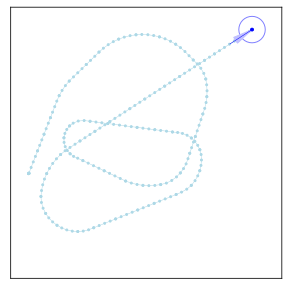

In [87]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["kalman_prediction.txt"])

### Finally, the test.
This will fail even if there are small errors in your program above. However it should not fail if your output of the first 30 steps matches the reference output above.

In [88]:
# Test of the prediction step, compares to hardcoded reference solution.
from hashlib import shake_128
from lego_robot import *
from numpy import *
ref_result = "2785c91792ca746dccbcc861e1ee603ba9e104dfb1a2ec6c6dd12df045cb816859a8ee071a34e73f"\
"7d277483b66057be541bd40fe99f4fe92620a6381a4ae7d2c61c915b3a7c8d5e043360c8af26f9aa"\
"f3208886ce8e1c8e88cb14da9dbf523884163f2922473ecd755982f050dd001dcabd4ce75ed68197"\
"10252bc7e109c1aed03d3d2dfe65c5e3d5c58f487bdc0ac82e290d305e8e9be957c17f261c21f0e6"\
"67dde9ddb29434b3885bfb37636be3f79e843cde803033b3d8c3e2301578829999df315c20c59fa7"\
"ea76ec3f3bff7b4a26de96c3ebed4ef920e2f7ba0792d90fe95b9db8b79be61e131f4eb5ba3e3571"\
"89f407d656a74fec2d12a9fed72e2b872febebb087537fd63c21ddfa53253d0f1d768ac5499f594c"\
"7f805aa0a394c77adc21843dedeb9ac9e6d08d3f13536ba72a58d773c83373727b85c866abd0eac9"\
"9b4d7eeb74670f72cb514aa95c25492579b8ba2a05c1a9445901c106eb63abb042c1d8d4b5b89d2f"\
"d7487c644ac2e5d63e42739b0ab29829ed067b16fc5a0a1b21a5cb7210ed35543bdf1c4daf8c86ff"\
"edd26faaf2b0aa02cf874f1d6683e81d3aaf0172183b92f91f2e9d9e24a9c15a767ebd3151afb448"\
"3bdd3c1ee2de1c3eec99c8f5d3efd52810d48568d6793f47e692575472c44cfb4d1a6240936e414c"\
"6ae5898351c7a28f3b7f9fa9ca0b06d323f7a5f0010e17e4e5fa0b4b56a703af5d98c7f29b3567d9"\
"9054255f434a4a2a7cfe061e8d346e30346becae2962a7e84f56dad09c2f5591521555a2"

def public_test(the_kf_class):
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.

    # Measured start position.
    initial_state = array([1850.0, 1897.0, 213.0 / 180.0 * pi])
    # Covariance at start position.
    initial_covariance = diag([100.0**2, 100.0**2, (10.0 / 180.0 * pi) ** 2])
    # Setup filter.
    kf = the_kf_class(initial_state, initial_covariance,
                              robot_width,
                              control_motion_factor, control_turn_factor)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")

    # This is the Kalman filter loop, without the correction step.
    h, c = shake_128(), ""
    for i, m in enumerate(logfile.motor_ticks):
        # Prediction.
        control = array(m) * ticks_to_mm
        kf.predict(control)
        s = "x=%7.2f|y=%7.2f|t=%6.3f|%6.1f|%7.1f|%6.3f|%7.1f|%6.1f|%6.3f|%6.3f|%6.3f|%5.3f|" %\
            (tuple(kf.state)+tuple(kf.covariance.reshape(9)))
        h.update(s.encode())
        #print(i, s)
        c += h.hexdigest(2)
    #for s in [c[j:j+80] for j in range(0,len(c),80)]: print('"'+s+'"\\')
    if c != ref_result:
        print("Your result does not match the reference result.")
        print("First mismatch at index",
             min(i for i in range(len(ref_result)) if c[i] != ref_result[i]) // 4)
        return False
    return True

assert(public_test(ExtendedKalmanFilter_4))

<ipython-input-80-1219ba714060>:14: RuntimeWarning: invalid value encountered in double_scalars
  R=l/alpha
<ipython-input-80-1219ba714060>:14: RuntimeWarning: divide by zero encountered in double_scalars
  R=l/alpha


## Second, the correction step
Similarly to our approach for the prediction step, we will need for the correction step:

- The measurement function itself, we will call it $h()$.
- The Jacobian of the measurement function with respect to the state, $H = \partial h/\partial(x,y,\theta) = \partial(r,\alpha)/\partial(x,y,\theta)$.

Once we have these two components, we can put them together to obtain the correction step.

In [89]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/4gtNda-OD4Y" if "YouTube" in globals() else "//av.tib.eu/player/49014",
       width=560, height=315)

### Programming assignment. Implement the Jacobian matrix: derivative of measurement function with respect to the state (10 Points).

In [90]:
# This adds the derivative of the measurement function h,
# with respect to the state.
#
# slam_07_e_measurement_derivative
from lego_robot import *
from numpy import *

class ExtendedKalmanFilter_5(ExtendedKalmanFilter_4):
    @staticmethod
    def h(state, landmark, scanner_displacement):
        """Takes a (x, y, theta) state and a (x, y) landmark, and returns the
           measurement (range, bearing)."""
        dx = landmark[0] - (state[0] + scanner_displacement * cos(state[2]))
        dy = landmark[1] - (state[1] + scanner_displacement * sin(state[2]))
        r = sqrt(dx * dx + dy * dy)
        alpha = (arctan2(dy, dx) - state[2] + pi) % (2*pi) - pi

        return array([r, alpha])

    @staticmethod
    def dh_dstate(state, landmark, scanner_displacement):

        # --->>> Insert your code here.
        # Note that:
        # x y theta is state[0] state[1] state[2]
        # x_m y_m is landmark[0] landmark[1]
        # The Jacobian of h is a 2x3 matrix.

        #m = array([[1, 2, 3], [4, 5, 6]]) # Replace this.
        # YOUR CODE HERE
        #raise NotImplementedError()
        theta=state[2]
        dx = landmark[0] - (state[0] + scanner_displacement * cos(state[2]))
        dy = landmark[1] - (state[1] + scanner_displacement * sin(state[2]))
        q=dx * dx + dy * dy
        r=sqrt(q)
        
        dr_dx=-dx/r
        dr_dy=-dy/r
        dr_dt=scanner_displacement/r*(dx*sin(theta)-dy*cos(theta))

        da_dx=dy/q
        da_dy=-dx/q
        da_dt=-scanner_displacement/q*(dx*cos(theta)+dy*sin(theta))-1

        m=array([[dr_dx,dr_dy,dr_dt],[da_dx,da_dy,da_dt]])

        return m

if __name__ == '__main__':
    # If the partial derivative with respect to x, y, theta (the state)
    # are correct, then the numerical derivative and the analytical
    # derivative should be the same.

    # Set some variables. You should try other variables as well.
    x = 11.0
    y = 22.0
    theta = 125. / 180. * pi
    state = array([x, y, theta])
    landmark = (203.0, 20.0)
    scanner_displacement = 30.0
    w = 150.0

    # Compute derivative numerically.
    print("Numeric differentiation dx, dy, dtheta:")
    delta = 1e-7
    state_x = array([x + delta, y, theta])
    state_y = array([x, y + delta, theta])
    state_theta = array([x, y, theta + delta])
    hval = ExtendedKalmanFilter_5.h(state, landmark, scanner_displacement)
    dh_dx = (ExtendedKalmanFilter_5.h(state_x, landmark, scanner_displacement) - hval) / delta
    dh_dy = (ExtendedKalmanFilter_5.h(state_y, landmark, scanner_displacement) - hval) / delta
    dh_dtheta = (ExtendedKalmanFilter_5.h(state_theta, landmark, scanner_displacement) - hval) / delta
    dh_dstate_numeric = column_stack([dh_dx, dh_dy, dh_dtheta])
    print(dh_dstate_numeric)

    # Use the above code to compute the derivative analytically.
    print("Analytic differentiation dx, dy, dtheta:")
    dh_dstate_analytic = ExtendedKalmanFilter_5.dh_dstate(
        state, landmark, scanner_displacement)
    print(dh_dstate_analytic)

    # The difference should be close to zero (depending on the setting of
    # delta, above).
    print("Difference:")
    print(dh_dstate_numeric - dh_dstate_analytic)
    print("Seems correct:", allclose(dh_dstate_numeric, dh_dstate_analytic))

Numeric differentiation dx, dy, dtheta:
[[-9.92028504e-01  1.26012480e-01  2.22103350e+01]
 [-5.97530914e-04 -4.70404604e-03 -9.04372008e-01]]
Analytic differentiation dx, dy, dtheta:
[[-9.92028658e-01  1.26012464e-01  2.22103357e+01]
 [-5.97531632e-04 -4.70404662e-03 -9.04372013e-01]]
Difference:
[[ 1.54567504e-07  1.67745947e-08 -7.33399226e-07]
 [ 7.18408326e-10  5.73908717e-10  5.04587983e-09]]
Seems correct: True


In [91]:
# Test of the derivative of the measurement function with respect to the state.
from numpy import *
class ExtendedKalmanFilterRef:
    @staticmethod
    def h(state, landmark, scanner_displacement):
        """Takes a (x, y, theta) state and a (x, y) landmark, and returns the
           measurement (range, bearing)."""
        dx = landmark[0] - (state[0] + scanner_displacement * cos(state[2]))
        dy = landmark[1] - (state[1] + scanner_displacement * sin(state[2]))
        r = sqrt(dx * dx + dy * dy)
        alpha = (arctan2(dy, dx) - state[2] + pi) % (2*pi) - pi

        return array([r, alpha])

def public_test(the_kf_class):
    for experiment in range(1000):
        # Choose random state.
        x = random.uniform(-10,10)
        y = random.uniform(-10,10)
        theta = random.uniform(-180, 180) / 180. * pi
        state = array([x, y, theta])
        
        # Choose random landmark. Avoid zero and +/-pi angle
        # with robot heading since that is numerically unstable.
        l_r = random.uniform(1, 200)
        l_a = random.uniform(1e-2, pi-1e-2)
        if random.random() > 0.5: l_a *= -1
        landmark = (x + l_r*cos(theta+l_a), y + l_r*sin(theta+l_a))
        
        scanner_displacement = 30.0
        w = 150.0

        # Compute derivative numerically.
        delta = 1e-7
        state_x = array([x + delta, y, theta])
        state_y = array([x, y + delta, theta])
        state_theta = array([x, y, theta + delta])
        hval = ExtendedKalmanFilterRef.h(state, landmark, scanner_displacement)
        dh_dx = (ExtendedKalmanFilterRef.h(state_x, landmark, scanner_displacement) - hval) / delta
        dh_dy = (ExtendedKalmanFilterRef.h(state_y, landmark, scanner_displacement) - hval) / delta
        dh_dtheta = (ExtendedKalmanFilterRef.h(state_theta, landmark, scanner_displacement) - hval) / delta
        dh_dstate_numeric = column_stack([dh_dx, dh_dy, dh_dtheta])

        # Use the above code to compute the derivative analytically.
        dh_dstate_analytic = the_kf_class.dh_dstate(state, landmark, scanner_displacement)
    
        # The difference should be close to zero (depending on the setting of
        # delta, above).
        is_close = allclose(dh_dstate_numeric, dh_dstate_analytic, rtol=1e-5, atol=1e-5)
        if not is_close:
            print("For state:")
            print(state)
            print("...and landmark:")
            print(landmark)
            print("...the result of the numeric differentiation is:")
            print(dh_dstate_numeric)
            print("...your analytical result is:")
            print(dh_dstate_analytic)
            print("...resulting in a difference of:")
            print(dh_dstate_numeric - dh_dstate_analytic)
            return False
    return True
assert public_test(ExtendedKalmanFilter_5)

### The correction step
Now that we have the measurement function $h()$ and the Jacobian of $h()$, the matrix $H$, we can program the correction step.

In [92]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/Idb05ZsD2t0" if "YouTube" in globals() else "//av.tib.eu/player/49015",
       width=560, height=315)

### Final programming assignment: The correction step (15 Points).

In [97]:
# The full Kalman filter, consisting of prediction and correction step.
#
# slam_07_f_kalman_filter
from lego_robot import *
from numpy import *
from slam_d_library import get_observations, write_cylinders

class ExtendedKalmanFilter(ExtendedKalmanFilter_5):
    def __init__(self, state, covariance,
                 robot_width, scanner_displacement,
                 control_motion_factor, control_turn_factor,
                 measurement_distance_stddev, measurement_angle_stddev):
        # The state. This is the core data of the Kalman filter.
        self.state = state
        self.covariance = covariance

        # Some constants.
        self.robot_width = robot_width
        self.scanner_displacement = scanner_displacement
        self.control_motion_factor = control_motion_factor
        self.control_turn_factor = control_turn_factor
        self.measurement_distance_stddev = measurement_distance_stddev
        self.measurement_angle_stddev = measurement_angle_stddev
    
    # ***********************************************************
    # Note: You do not have to copy/paste your previous functions
    # here (as explained in the video), because in this Notebook,
    # they are automatically included.
    # ***********************************************************

    def correct(self, measurement, landmark):
        """The correction step of the Kalman filter."""
        # --->>> Put your new code here.
        #
        # You will have to compute:
        # H, using dh_dstate(...).
        H=self.dh_dstate(self.state, landmark, scanner_displacement)

        # Q, a diagonal matrix, from self.measurement_distance_stddev and
        Q=diag([self.measurement_distance_stddev**2, self.measurement_angle_stddev**2])

        #  self.measurement_angle_stddev (remember: Q contains variances).
        # K, from self.covariance, H, and Q.
        #  Use linalg.inv(...) to compute the inverse of a matrix.
        K=self.covariance@H.T@linalg.inv(H@self.covariance@H.T+Q)

        # The innovation: it is easy to make an error here, because the
        #  predicted measurement and the actual measurement of theta may have
        #  an offset of +/- 2 pi. So here is a suggestion:
        innovation = array(measurement) -self.h(self.state, landmark, self.scanner_displacement)
        innovation[1] = (innovation[1] + pi) % (2*pi) - pi

        self.state=self.state+K@innovation
        
        self.covariance=(eye(3)-K@H)@self.covariance
        # Then, you'll have to compute the new self.state.
        # And finally, compute the new self.covariance. Use eye(3) to get a 3x3
        #  identity matrix.
        #
        # Hints:
        # dot(A, B) or A @ B is the 'normal' matrix product (do not use: A*B).
        # A.T is the transposed of a matrix A (A itself is not modified).
        # linalg.inv(A) returns the inverse of A (A itself is not modified).
        # eye(3) returns a 3x3 identity matrix.

        # YOUR CODE HERE
        #raise NotImplementedError()

if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Cylinder extraction and matching constants.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0
    max_cylinder_distance = 300.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.

    # Measured start position.
    initial_state = array([1850.0, 1897.0, 213.0 / 180.0 * pi])
    # Covariance at start position.
    initial_covariance = diag([100.0**2, 100.0**2, (10.0 / 180.0 * pi) ** 2])
    # Setup filter.
    kf = ExtendedKalmanFilter(initial_state, initial_covariance,
                              robot_width, scanner_displacement,
                              control_motion_factor, control_turn_factor,
                              measurement_distance_stddev,
                              measurement_angle_stddev)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")
    logfile.read("robot_arena_landmarks.txt")
    reference_cylinders = [l[1:3] for l in logfile.landmarks]

    # Loop over all motor tick records and all measurements and generate
    # filtered positions and covariances.
    # This is the Kalman filter loop, with prediction and correction.
    states = []
    covariances = []
    matched_ref_cylinders = []
    for i in range(len(logfile.motor_ticks)):
        # Prediction.
        control = array(logfile.motor_ticks[i]) * ticks_to_mm
        kf.predict(control)

        # Correction.
        observations = get_observations(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset,
            kf.state, scanner_displacement,
            reference_cylinders, max_cylinder_distance)
        for j in range(len(observations)):
            kf.correct(*observations[j])

        # Log state, covariance, and matched cylinders for later output.
        states.append(kf.state)
        covariances.append(kf.covariance)
        matched_ref_cylinders.append([m[1] for m in observations])

    # Write all states, all state covariances, and matched cylinders to file.
    with open("kalman_prediction_and_correction.txt", "w") as f:
        for i in range(len(states)):
            # Output the center of the scanner, not the center of the robot.
            print("F %f %f %f" % \
                tuple(states[i] + [scanner_displacement * cos(states[i][2]),
                                   scanner_displacement * sin(states[i][2]),
                                   0.0]), file=f)
            # Convert covariance matrix to angle stddev1 stddev2 stddev-heading form
            e = ExtendedKalmanFilter.get_error_ellipse(covariances[i])
            print("E %f %f %f %f" % (e + (sqrt(covariances[i][2,2]),)), file=f)
            # Also, write matched cylinders.
            write_cylinders(f, "W C", matched_ref_cylinders[i])
            
            # You may use this to print out the first few steps and compare them with the values below.
            if i<30:
                print("\t%3d: x=%7.2f|y=%7.2f|t=%6.3f" % ((i,) + tuple(states[i])), end="|")
                print("%6.1f|%7.1f|%6.3f|%7.1f|%6.1f|%6.3f|%6.3f|%6.3f|%5.3f|" % tuple(covariances[i].reshape(9)))

<ipython-input-80-1219ba714060>:14: RuntimeWarning: invalid value encountered in double_scalars
  R=l/alpha
<ipython-input-80-1219ba714060>:14: RuntimeWarning: divide by zero encountered in double_scalars
  R=l/alpha


	  0: x=1836.23|y=1868.00|t= 3.730|5582.7|-1067.6|-2.503|-1067.6|4739.6| 2.450|-2.503| 2.450|0.010|
	  1: x=1832.76|y=1861.56|t= 3.730|4053.0|-1103.6|-2.240|-1103.6|3282.7| 2.115|-2.240| 2.115|0.007|
	  2: x=1831.35|y=1858.99|t= 3.730|3206.7|-1007.9|-1.932|-1007.9|2541.0| 1.795|-1.932| 1.795|0.005|
	  3: x=1830.47|y=1857.03|t= 3.730|2659.7| -904.0|-1.681| -904.0|2081.2| 1.547|-1.681| 1.547|0.004|
	  4: x=1830.06|y=1855.64|t= 3.729|2274.2| -812.2|-1.482| -812.2|1765.6| 1.356|-1.482| 1.356|0.003|
	  5: x=1829.59|y=1854.71|t= 3.729|1987.2| -734.4|-1.322| -734.4|1534.5| 1.205|-1.322| 1.205|0.003|
	  6: x=1829.29|y=1854.11|t= 3.729|1764.9| -668.7|-1.192| -668.7|1357.6| 1.084|-1.192| 1.084|0.003|
	  7: x=1829.07|y=1853.71|t= 3.729|1587.5| -613.1|-1.085| -613.1|1217.7| 0.985|-1.085| 0.985|0.002|
	  8: x=1828.93|y=1853.42|t= 3.729|1442.6| -565.7|-0.996| -565.7|1104.1| 0.902|-0.996| 0.902|0.002|
	  9: x=1828.85|y=1853.07|t= 3.729|1322.1| -524.8|-0.919| -524.8|1010.0| 0.832|-0.919| 0.832|0.002|


### Some numerical values to check your output:

	  0: x=1836.23|y=1868.00|t= 3.730|5582.7|-1067.6|-2.503|-1067.6|4739.6| 2.450|-2.503| 2.450|0.010|
	  1: x=1832.76|y=1861.56|t= 3.730|4053.0|-1103.6|-2.240|-1103.6|3282.7| 2.115|-2.240| 2.115|0.007|
	  2: x=1831.35|y=1858.99|t= 3.730|3206.7|-1007.9|-1.932|-1007.9|2541.0| 1.795|-1.932| 1.795|0.005|
	  3: x=1830.47|y=1857.03|t= 3.730|2659.7| -904.0|-1.681| -904.0|2081.3| 1.547|-1.681| 1.547|0.004|
	  4: x=1830.06|y=1855.64|t= 3.729|2274.2| -812.2|-1.482| -812.2|1765.6| 1.356|-1.482| 1.356|0.003|
	  5: x=1829.59|y=1854.71|t= 3.729|1987.2| -734.4|-1.322| -734.4|1534.5| 1.205|-1.322| 1.205|0.003|
	  6: x=1829.29|y=1854.11|t= 3.729|1764.9| -668.7|-1.192| -668.7|1357.6| 1.084|-1.192| 1.084|0.003|
	  7: x=1829.07|y=1853.71|t= 3.729|1587.5| -613.1|-1.085| -613.1|1217.7| 0.985|-1.085| 0.985|0.002|
	  8: x=1828.93|y=1853.42|t= 3.729|1442.6| -565.7|-0.996| -565.7|1104.1| 0.902|-0.996| 0.902|0.002|
	  9: x=1828.85|y=1853.07|t= 3.729|1322.1| -524.8|-0.919| -524.8|1010.0| 0.832|-0.919| 0.832|0.002|
	 10: x=1828.74|y=1852.91|t= 3.729|1220.1| -489.2|-0.854| -489.2| 930.8| 0.772|-0.854| 0.772|0.002|
	 11: x=1828.72|y=1852.72|t= 3.729|1132.8| -458.1|-0.797| -458.1| 863.1| 0.720|-0.797| 0.720|0.002|
	 12: x=1828.80|y=1852.55|t= 3.729|1057.2| -430.6|-0.747| -430.6| 804.7| 0.674|-0.747| 0.674|0.002|
	 13: x=1809.61|y=1839.71|t= 3.729| 994.3| -369.2|-0.664| -369.2| 738.3| 0.577|-0.664| 0.577|0.005|
	 14: x=1775.99|y=1817.00|t= 3.727| 974.9| -271.4|-0.519| -271.4| 688.5| 0.398|-0.519| 0.398|0.008|
	 15: x=1742.96|y=1794.71|t=-2.553| 957.4| -192.1|-0.416| -192.1| 649.3| 0.296|-0.416| 0.296|0.008|
	 16: x=1710.19|y=1772.95|t=-2.560| 938.4| -130.6|-0.309| -130.6| 626.4| 0.258|-0.309| 0.258|0.009|
	 17: x=1711.92|y=1774.65|t=-2.559| 867.5| -141.5|-0.360| -141.5| 592.4| 0.358|-0.360| 0.358|0.006|
	 18: x=1675.96|y=1751.64|t=-2.561| 856.6|  -87.2|-0.245|  -87.2| 570.7| 0.248|-0.245| 0.248|0.009|
	 19: x=1641.49|y=1729.37|t=-2.562| 839.7|  -47.1|-0.149|  -47.1| 552.6| 0.174|-0.149| 0.174|0.009|
	 20: x=1608.65|y=1707.96|t=-2.564| 815.5|  -18.2|-0.068|  -18.2| 536.4| 0.133|-0.068| 0.133|0.009|
	 21: x=1576.78|y=1687.07|t=-2.566| 785.1|    2.6|-0.007|    2.6| 522.3| 0.093|-0.007| 0.093|0.009|
	 22: x=1579.03|y=1688.79|t=-2.566| 700.4|  -23.9|-0.082|  -23.9| 488.5| 0.202|-0.082| 0.202|0.005|
	 23: x=1543.01|y=1665.65|t=-2.565| 687.8|    4.1| 0.014|    4.1| 479.5| 0.097| 0.014| 0.097|0.009|
	 24: x=1506.98|y=1641.49|t=-2.550| 723.7|   49.8|-0.189|   49.8| 496.1|-0.140|-0.189|-0.140|0.010|
	 25: x=1506.01|y=1641.02|t=-2.556| 687.6|   38.7|-0.312|   38.7| 475.1|-0.034|-0.312|-0.034|0.007|
	 26: x=1468.48|y=1615.44|t=-2.556| 716.4|   87.9|-0.317|   87.9| 490.6|-0.178|-0.317|-0.178|0.009|
	 27: x=1433.43|y=1591.74|t=-2.560| 662.9|   97.0|-0.025|   97.0| 488.8|-0.122|-0.025|-0.122|0.008|
	 28: x=1399.50|y=1568.69|t=-2.562| 632.5|  108.5| 0.040|  108.5| 488.6|-0.135| 0.040|-0.135|0.008|
	 29: x=1362.78|y=1543.96|t=-2.555| 667.0|  143.8|-0.189|  143.8| 505.0|-0.268|-0.189|-0.268|0.009|

### Finally, the test.
This will fail even if there are small errors in your program above. However it should not fail if your output of the first 30 steps matches the reference output above.

In [98]:
# Test of the full Kalman filter, compares to hardcoded reference solution.
from hashlib import shake_128
from lego_robot import *
from numpy import *
from slam_d_library import get_observations, write_cylinders

ref_result = "d99d512c61f4d287b48f686ac3afe20ea8e5404171fc2be619716b2c21bc0687b60debab34521240"\
"98ec15ff2d63b301cb919e062f2228ab8d5a7d1ab722d778162ff8d3cf1acc934fe6949732a58994"\
"b8d67ecf125150588d03f6339a901d986378b6e5d970349b32470784b3bff8af7ad5d1f5ae3b4eaf"\
"f1e6bb7a587833d8ec625b64b57a167965809a2a4f743f81277b153b4785b5b246c2fa6033699b19"\
"f580881713b3e5accede26fc13f033f13dd4421368a8568a0a965e8584c91abb6b4e9bdec451b8f0"\
"b37dfa54758ce851d39e2061259edca4fde9a39ddf7e771131a98fd23ed38036abaaa43c9e2999c5"\
"da6f67041ec59d2ff413852cac2617755308539f241c73d47bced6e209dc3d4ae52b5550dbad1e1e"\
"efa8fe8adb69b9211bc6c8f3d249049b047a53d10664254695eee5f5726dada5866f942d1a69a2e7"\
"439883dc5d4a85e8a6b97f74f7b34e26636904337a609d3050676d0d0bd39710d26e99d02f82d7d6"\
"7c5bb0f000f2cdf677d238575a2d8e478e903a5143070ca5424a7aa64de28e5045bbdcf88ec190b5"\
"bfb277f766a48264cb5d04de531e8bdf733dda9c29bf99675fdbbd10e50b364437cc9c90be334c33"\
"a858e3827d6e43ca98330150379d39653f368429848a0f1844b5539571589203d3ee0bb13113701f"\
"c3a5719bd6314f73990f81dec738430e09868d5c72a580f840fb01d371978bb615911b57aa1f5672"\
"aa96ec69cf06ad97fbf3a1d4be5569f6ebfd15485354a4ab3e2708887fee05111b3cc238"

def public_test(the_kf_class):
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0
    # Cylinder extraction and matching constants.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0
    max_cylinder_distance = 300.0
    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.

    # Measured start position.
    initial_state = array([1850.0, 1897.0, 213.0 / 180.0 * pi])
    # Covariance at start position.
    initial_covariance = diag([100.0**2, 100.0**2, (10.0 / 180.0 * pi) ** 2])
    # Setup filter.
    kf = the_kf_class(initial_state, initial_covariance, robot_width, scanner_displacement,
        control_motion_factor, control_turn_factor,
        measurement_distance_stddev, measurement_angle_stddev)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")
    logfile.read("robot_arena_landmarks.txt")
    reference_cylinders = [l[1:3] for l in logfile.landmarks]

    # This is the Kalman filter loop, without the correction step.
    h, c = shake_128(), ""
    for i, m in enumerate(logfile.motor_ticks):
        # Prediction.
        control = array(m) * ticks_to_mm
        kf.predict(control)
        # Correction.
        observations = get_observations(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset,
            kf.state, scanner_displacement,
            reference_cylinders, max_cylinder_distance)
        for j in range(len(observations)):
            kf.correct(*observations[j])
        s = "x=%7.2f|y=%7.2f|t=%6.3f|%6.1f|%7.1f|%6.3f|%7.1f|%6.1f|%6.3f|%6.3f|%6.3f|%5.3f|" %\
            (tuple(kf.state)+tuple(kf.covariance.reshape(9)))
        h.update(s.encode())
        #print(i, s)
        c += h.hexdigest(2)
    #for s in [c[j:j+80] for j in range(0,len(c),80)]: print('"'+s+'"\\')
    if c != ref_result:
        print("Your result does not match the reference result.")
        print("First mismatch at index",
             min(i for i in range(len(ref_result)) if c[i] != ref_result[i]) // 4)
        return False
    return True

assert(public_test(ExtendedKalmanFilter))

<ipython-input-80-1219ba714060>:14: RuntimeWarning: invalid value encountered in double_scalars
  R=l/alpha
<ipython-input-80-1219ba714060>:14: RuntimeWarning: divide by zero encountered in double_scalars
  R=l/alpha


## Congratulations! Let's have a look at the results
The trajectory is both: quite smooth *and* globally correct. As the video shows, our Kalman filter solution even works if we take only a maximum of one observed cylinder in each step (i.e., even if we observe multiple cylinders, we pick only one of them). If you compare this to our earlier approach from Unit B, using the estimation of a similarity transform, you will note that this had led to a much more jagged trajectory, and it would not have worked at all when using only a single observed landmark in each step.

In [99]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/0bZNOfs4Tmg" if "YouTube" in globals() else "//av.tib.eu/player/49016",
       width=560, height=315)

In [100]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["kalman_prediction_and_correction.txt", "robot4_reference.txt",
                                "robot_arena_landmarks.txt"])